# LHC collimation study

In [1]:
import numpy as np
from pathlib import Path

import xobjects as xo
import xtrack as xt
import xcoll as xc

### Import a line

In [2]:
line = xt.Line.from_json(f'lhc_run3_b1.json')

Loading line from dict:   0%|          | 0/102795 [00:00<?, ?it/s]

Done loading line from dict.           


### Install and configure collimators using `xcoll`

In [3]:
colldb = xc.CollimatorDatabase.from_yaml('collimators_simplified.yaml', beam='1')
colldb.install_everest_collimators(line=line, verbose=True)

Installing tcspm.b4l7.b1        as EverestCollimator
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Installing tctph.4l5.b1         as EverestCollimator
Installing tcsg.5l3.b1          as EverestCollimator
Installing tctpv.4l1.b1         as EverestCollimator
Installing tcp.6l3.b1           as EverestCollimator
Installing tcp.d6l7.b1          as EverestCollimator
Installing tctph.4l1.b1         as EverestCollimator
Installing tctpv.4l5.b1         as EverestCollimator
Installing tcp.c6l7.b1          as EverestCollimator
Installing tcsg.b5l7.b1         as EverestCollimator
Installing tcsg.4r3.b1          as EverestCollimator


Slicing line:   0%|          | 0/102795 [00:00<?, ?it/s]

#### Aperture sanity check

In [4]:
df_with_coll = line.check_aperture()

Checking aperture:   0%|          | 0/102784 [00:00<?, ?it/s]

Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]


#### Build tracker

In [5]:
line.build_tracker()

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


#### Set collimators gaps (optics computed internally)

In [6]:
line.collimators.assign_optics()

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


#### Simulate impact of a pencil beam on the jaws of a given collimator

In [7]:
# Generate distribution
tcp  = 'tcp.c6l7.b1'
part = line[tcp].generate_pencil(num_particles=int(5e4))

Collimator tcp.c6l7.b1 is converging.


In [8]:
# Enable multicore CPU parallelization
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [9]:
# Track
line.scattering.enable()
line.track(part, num_turns=30, with_progress=2)

Tracking:   0%|          | 0/30 [00:00<?, ?it/s]

#### Analysis of tracking results - loss maps

In [10]:
# Disable scattering and multi-core parallilization
line.scattering.disable()
line.discard_tracker()
line.build_tracker(_context=xo.context_default)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [11]:
ThisLM = xc.LossMap(line, line_is_reversed=False, part=part)
ThisLM.to_json(file='mylossmap.json')

Performing the aperture losses refinement.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


#### Plot (same tool as for measured loss-map)

In [12]:
import lossmaps as lm

lmap = lm.SimulatedLossMap(lmtype=lm.LMType['B1H'], machine=lm.Machine.LHC, energy=6800, particle=lm.Particle.PROTON)
lmap.load_data_json(json_files='mylossmap.json')

 If you are on SWAN and did not expect this warning, then restart and load the 'NXCals Pro' software stack.
Maximum inefficiency in the DS is 0.000515.


Warning, `show_layout` temporarily not supported.


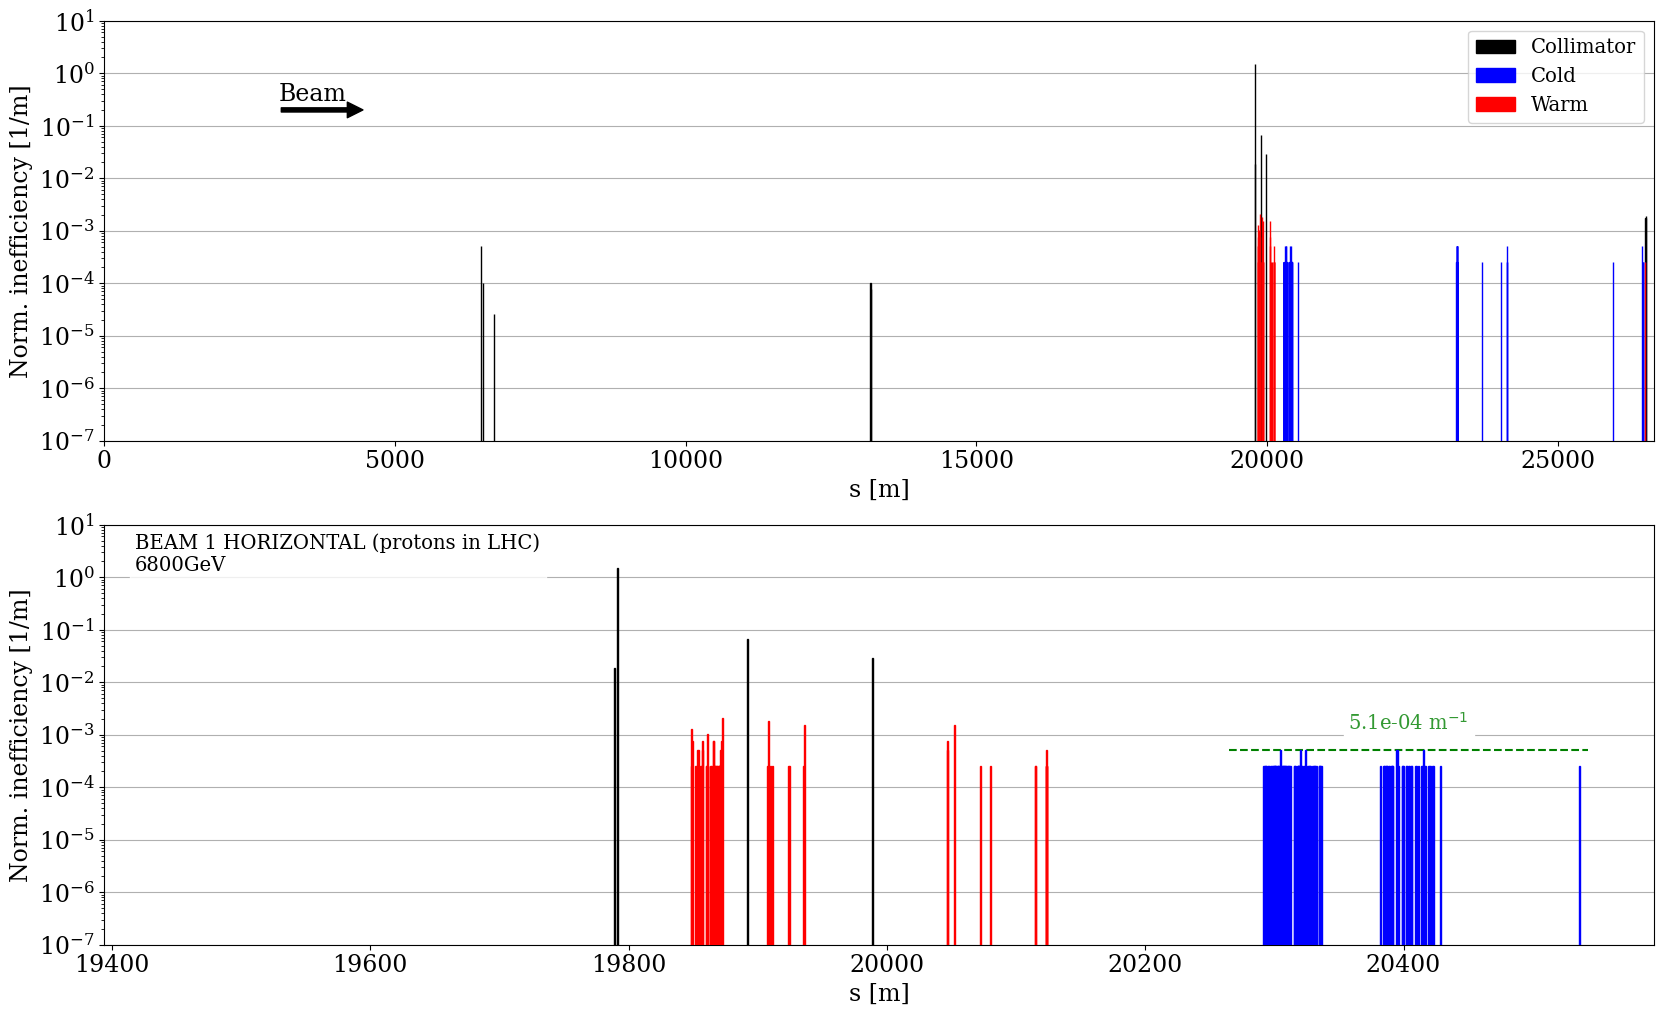

In [13]:
# Plot the loss map
_ = lm.plot_lossmap(lmap)